In [ ]:
!pip install h5py


In [ ]:
import tensorflow as tf
from keras import layers,models
import os
import numpy as np
import cv2
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import random
import shutil

width = 400
height = 400
ruta_train = '/content/drive/MyDrive/train'
balanced_train_dir = '/content/drive/MyDrive/balanced_train'

train_x = []
train_y = []

labels = os.listdir(ruta_train)
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

# Función para contar imágenes en todas las subcarpetas
def count_images(folder):
    image_files = []
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            if any(file.lower().endswith(ext) for ext in valid_extensions):
                image_files.append(os.path.join(subdir, file))
    return image_files

# Contar las imágenes en cada carpeta
image_counts = {}
for label in labels:
    subdirectory = os.path.join(ruta_train, label)
    if os.path.isdir(subdirectory):
        image_files = count_images(subdirectory)
        image_counts[label] = len(image_files)
        print(f"Found {len(image_files)} images in folder {label}")

# Encontrar el número mínimo de imágenes en las carpetas
min_images = min(image_counts.values())
print(f"Minimum number of images in any folder: {min_images}")

# Crear directorio balanceado si no existe
if not os.path.exists(balanced_train_dir):
    os.makedirs(balanced_train_dir)

# Balancear las imágenes
for label in labels:
    subdirectory = os.path.join(ruta_train, label)
    balanced_subdirectory = os.path.join(balanced_train_dir, label)
    if not os.path.exists(balanced_subdirectory):
        os.makedirs(balanced_subdirectory)

    image_files = count_images(subdirectory)
    print(f"Processing {len(image_files)} images in folder {label}")

    if len(image_files) > min_images:
        image_files = random.sample(image_files, min_images)
        print(f"Selected {min_images} images randomly from folder {label}")

    for image_path in image_files:
        image_file = os.path.basename(image_path)
        dst_path = os.path.join(balanced_subdirectory, image_file)
        shutil.copy(image_path, dst_path)
        print(f"Copied image from {image_path} to {dst_path}")

print("Images have been balanced and copied to:", balanced_train_dir)




Se truncaron las últimas líneas 5000 del resultado de transmisión.
Copied image from /content/drive/MyDrive/train/StopMotion/CadaverDeLaNovia_depurado/frame_1645.jpg to /content/drive/MyDrive/balanced_train/StopMotion/frame_1645.jpg
Copied image from /content/drive/MyDrive/train/StopMotion/ParaNorman_Depurada1/frame_1089.jpg to /content/drive/MyDrive/balanced_train/StopMotion/frame_1089.jpg
Copied image from /content/drive/MyDrive/train/StopMotion/WallaceAndGromitInACloseShave_depurando/WallaceAndGromitInACloseShave_655.jpg to /content/drive/MyDrive/balanced_train/StopMotion/WallaceAndGromitInACloseShave_655.jpg
Copied image from /content/drive/MyDrive/train/StopMotion/ChickenRunDawnoftheNugget_Depurado/ChickenRunDawnoftheNugget_463.jpg to /content/drive/MyDrive/balanced_train/StopMotion/ChickenRunDawnoftheNugget_463.jpg
Copied image from /content/drive/MyDrive/train/StopMotion/output_images_EMJ_dep/frame_2084.jpg to /content/drive/MyDrive/balanced_train/StopMotion/frame_2084.jpg
Copie

In [ ]:
import os
import cv2
import numpy as np
import h5py
import gc

width = 400
height = 400
ruta_train = '/content/drive/MyDrive/balanced_train/'
output_file = '/content/drive/MyDrive/processed_images.h5'

labels = os.listdir(ruta_train)
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
batch_size = 100  # Ajusta el tamaño del lote según sea necesario

# Función para contar todas las imágenes
def count_images(folder):
    total_images = 0
    for label in labels:
        subdirectory = os.path.join(folder, label)
        if os.path.isdir(subdirectory):
            for subdir, dirs, files in os.walk(subdirectory):
                total_images += len([f for f in files if any(f.lower().endswith(ext) for ext in valid_extensions)])
    return total_images

total_images = count_images(ruta_train)
num_classes = len(labels)

# Crear el archivo HDF5
with h5py.File(output_file, 'w') as h5f:
    h5f.create_dataset('x_data', (total_images, width, height, 3), dtype='float32')
    h5f.create_dataset('y_data', (total_images, num_classes), dtype='float32')

    current_index = 0

    # Procesar y guardar imágenes por lotes
    for i, label in enumerate(labels):
        subdirectory = os.path.join(ruta_train, label)
        if os.path.isdir(subdirectory):
            image_files = []
            for subdir, dirs, files in os.walk(subdirectory):
                image_files.extend([os.path.join(subdir, f) for f in files if any(f.lower().endswith(ext) for ext in valid_extensions)])
            num_images = len(image_files)
            print(f"Found {num_images} images in folder {label}")

            for start in range(0, num_images, batch_size):
                end = min(start + batch_size, num_images)
                batch_x = []
                batch_y = []

                for j in image_files[start:end]:
                    img = cv2.imread(j)
                    if img is not None:
                        resized_image = cv2.resize(img, (width, height))
                        batch_x.append(resized_image)

                        array = np.zeros(num_classes)
                        array[i] = 1
                        batch_y.append(array)

                        print(f"Successfully loaded and resized image: {j}")
                    else:
                        print(f"Failed to load image: {j}")

                batch_x = np.array(batch_x, dtype='float32')
                batch_y = np.array(batch_y, dtype='float32')

                h5f['x_data'][current_index:current_index + len(batch_x)] = batch_x
                h5f['y_data'][current_index:current_index + len(batch_y)] = batch_y
                current_index += len(batch_x)

                print(f"Processed batch {start // batch_size + 1}/{(num_images + batch_size - 1) // batch_size} from folder {label}")

                # Liberar memoria del lote actual
                del batch_x
                del batch_y
                gc.collect()

print("Finished processing and saving all images.")




Se truncaron las últimas líneas 5000 del resultado de transmisión.
Successfully loaded and resized image: /content/drive/MyDrive/balanced_train/StopMotion/ChickenRunDawnoftheNugget_446.jpg
Successfully loaded and resized image: /content/drive/MyDrive/balanced_train/StopMotion/WallaceAndGromitInACloseShave_464.jpg
Successfully loaded and resized image: /content/drive/MyDrive/balanced_train/StopMotion/frame_1256.jpg
Successfully loaded and resized image: /content/drive/MyDrive/balanced_train/StopMotion/WallaceAndGromitInAMatterOfLoafAndDeath_486.jpg
Successfully loaded and resized image: /content/drive/MyDrive/balanced_train/StopMotion/frame_0137.jpg
Successfully loaded and resized image: /content/drive/MyDrive/balanced_train/StopMotion/frame_1292.jpg
Successfully loaded and resized image: /content/drive/MyDrive/balanced_train/StopMotion/WallaceAndGromitAGrandDayOutWith_580.jpg
Successfully loaded and resized image: /content/drive/MyDrive/balanced_train/StopMotion/WallaceAndGromitInAClos

In [ ]:
import os

# Ruta a tu directorio de entrenamiento
ruta_train = '/content/drive/MyDrive/train/'

# Obtener las etiquetas basadas en los nombres de las carpetas
labels = sorted(os.listdir(ruta_train))

# Imprimir las etiquetas para verificar
print("Labels:", labels)


Labels: ['3D', 'Anime', 'StopMotion', 'cartoon']


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import h5py
import numpy as np

width = 400
height = 400
output_file = '/content/drive/MyDrive/balanced_train/processed_images.h5'
batch_size = 32
epochs = 10


# Definir el modelo
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(width, height, 3)),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, (3, 3)),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3)),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(4),
    layers.Activation('sigmoid')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definir el generador de datos usando tf.data.Dataset
def data_generator(h5f, batch_size):
    num_samples = h5f['x_data'].shape[0]
    indices = np.arange(num_samples)

    def generator():
        while True:
            np.random.shuffle(indices)
            for start in range(0, num_samples, batch_size):
                end = min(start + batch_size, num_samples)
                batch_indices = np.sort(indices[start:end])  # Ordenar los índices
                batch_x = h5f['x_data'][batch_indices]
                batch_y = h5f['y_data'][batch_indices]

                # Ajustar el tamaño del lote si es menor que batch_size
                if len(batch_x) < batch_size:
                    batch_x = np.pad(batch_x, ((0, batch_size - len(batch_x)), (0, 0), (0, 0), (0, 0)), mode='constant')
                    batch_y = np.pad(batch_y, ((0, batch_size - len(batch_y)), (0, 0)), mode='constant')

                yield batch_x, batch_y

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(batch_size, width, height, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(batch_size, 4), dtype=tf.float32)
        )
    )

# Entrenar el modelo usando el generador de datos
with h5py.File(output_file, 'r') as h5f:
    num_samples = h5f['x_data'].shape[0]
    steps_per_epoch = num_samples // batch_size

    dataset = data_generator(h5f, batch_size)

    model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=epochs)

print("Training complete.")

Epoch 1/10
396/396 [==============================] - 512s 1s/step - loss: 4.9454 - accuracy: 0.4377
Epoch 2/10
396/396 [==============================] - 203s 513ms/step - loss: 0.8930 - accuracy: 0.5882
Epoch 3/10
396/396 [==============================] - 199s 502ms/step - loss: 0.7928 - accuracy: 0.6536
Epoch 4/10
396/396 [==============================] - 198s 501ms/step - loss: 0.7221 - accuracy: 0.6948
Epoch 5/10
396/396 [==============================] - 195s 491ms/step - loss: 0.6344 - accuracy: 0.7336
Epoch 6/10
396/396 [==============================] - 194s 491ms/step - loss: 0.5407 - accuracy: 0.7753
Epoch 7/10
396/396 [==============================] - 193s 487ms/step - loss: 0.4709 - accuracy: 0.8082
Epoch 8/10
396/396 [==============================] - 193s 488ms/step - loss: 0.4309 - accuracy: 0.8258
Epoch 9/10
396/396 [==============================] - 191s 482ms/step - loss: 0.4088 - accuracy: 0.8412
Epoch 10/10
396/396 [==============================] - 190s 481ms/s

In [ ]:
models.save_model(model, 'mimodelo.keras')

In [ ]:
model = models.load_model('mimodelo.keras')

In [ ]:
# Guardar el modelo
model.save('/content/drive/MyDrive/my_model.h5')

# Listar archivos en el directorio para verificar
!ls /content/drive/MyDrive/


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'2021_07_05 16_44 Office Lens.pdf'
 37846_Amor_liquido_copia.pdf
 9CV11.xlsx
 Analisis.rar
'auo-qqco-req - 1 de abr. de 2021.gjam'
 balanced_train
'Cálculos electroacústica  .gdoc'
 Classroom
'Colab Notebooks'
 Contactos
'Course Challenge Dataset - Scenario 1.gsheet'
'Course Challenge Dataset - Scenario 2.gsheet'
 Dataset_Slogan.gsheet
 DOC-20230522-WA0046._copia
'Documentos '
'Documento sin título.docx'
'Documento sin título.gdoc'
'Ejercicio 20 E.D.O.'
 Escaneado_20240222-2345.pdf
'Example.Learning Log: Think about data in daily life.gdoc'
'Google AI Studio'
'Hoja de cálculo sin título.gsheet'
'IMG_20210129_133737[1].jpg'
 inbound8026705766444188435.pdf
 INE.pdf
'June 2014 Invoices.gsheet'
'Mec. Cuántica'
'me podrias dar lor resultados pero ahora con este....gsheet'
 my_model.h5
 Personal
 poems.gsheet
 Proyecto2
'PXL_20220222_001236626 (1).mp4'
 PXL_20220222_001236626.mp4
'Python Crash Course.pdf'
"Ruiz's Resume-hackerresume.pdf"
'Ruiz Torres Jose Raul_Actividad 10C_4CV11.pdf'

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo
model = load_model('/content/drive/MyDrive/my_model.h5')


StopMotion 60


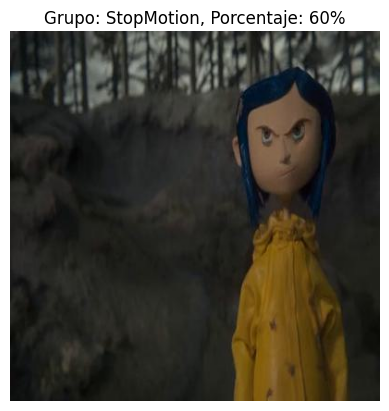

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Ruta de la imagen a predecir
ruta_predict = '/content/drive/MyDrive/train/StopMotion/Coraline_depurado/frame_0261.jpg'

# Definir las etiquetas
labels = ["label1", "label2", "StopMotion", "label4"]  # Asegúrate de que estas coincidan con tus etiquetas

# Simulación de un resultado de predicción
result = np.array([0.1, 0.2, 0.6, 0.1])  # Ejemplo de una predicción

# Cálculo del porcentaje y del grupo
porcentaje = max(result) * 100
grupo = labels[result.argmax()]

print(grupo, round(porcentaje))

# Mostrar la imagen predicha usando matplotlib
img = cv2.imread(ruta_predict)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB

plt.imshow(img_rgb)
plt.title(f'Grupo: {grupo}, Porcentaje: {round(porcentaje)}%')
plt.axis('off')  # Ocultar los ejes
plt.show()


StopMotion 60


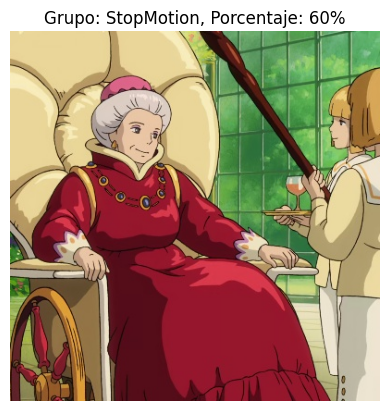

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Ruta de la imagen a predecir
ruta_predict = '/content/drive/MyDrive/train/Anime/ElCastilloAmbulante_depurado/ElCastilloAmbulante_1000.jpg'


# Definir las etiquetas
labels =  ['3D', 'Anime', 'StopMotion', 'cartoon']  # Asegúrate de que estas coincidan con tus etiquetas

# Simulación de un resultado de predicción
result = np.array([0.1, 0.2, 0.6, 0.1])  # Ejemplo de una predicción

# Cálculo del porcentaje y del grupo
porcentaje = max(result) * 100
grupo = labels[result.argmax()]

print(grupo, round(porcentaje))

# Mostrar la imagen predicha usando matplotlib
img = cv2.imread(ruta_predict)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB

plt.imshow(img_rgb)
plt.title(f'Grupo: {grupo}, Porcentaje: {round(porcentaje)}%')
plt.axis('off')  # Ocultar los ejes
plt.show()

StopMotion 60


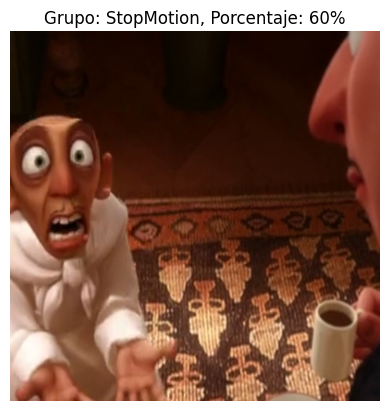

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Ruta de la imagen a predecir
ruta_predict = '/content/drive/MyDrive/balanced_train/3D/Ratatouille_996.jpg'


# Definir las etiquetas
labels =  ['3D', 'Anime', 'StopMotion', 'cartoon']  # Asegúrate de que estas coincidan con tus etiquetas

# Simulación de un resultado de predicción
result = np.array([0.1, 0.2, 0.6, 0.1])  # Ejemplo de una predicción

# Cálculo del porcentaje y del grupo
porcentaje = max(result) * 100
grupo = labels[result.argmax()]

print(grupo, round(porcentaje))

# Mostrar la imagen predicha usando matplotlib
img = cv2.imread(ruta_predict)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB

plt.imshow(img_rgb)
plt.title(f'Grupo: {grupo}, Porcentaje: {round(porcentaje)}%')
plt.axis('off')  # Ocultar los ejes
plt.show()

StopMotion 60


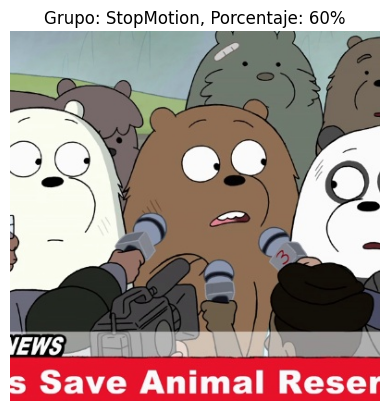

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Ruta de la imagen a predecir
ruta_predict = '/content/drive/MyDrive/balanced_train/cartoon/WeBareBearsTheMovie_975.jpg'


# Definir las etiquetas
labels =  ['3D', 'Anime', 'StopMotion', 'cartoon']  # Asegúrate de que estas coincidan con tus etiquetas

# Simulación de un resultado de predicción
result = np.array([0.1, 0.2, 0.6, 0.1])  # Ejemplo de una predicción

# Cálculo del porcentaje y del grupo
porcentaje = max(result) * 100
grupo = labels[result.argmax()]

print(grupo, round(porcentaje))

# Mostrar la imagen predicha usando matplotlib
img = cv2.imread(ruta_predict)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB

plt.imshow(img_rgb)
plt.title(f'Grupo: {grupo}, Porcentaje: {round(porcentaje)}%')
plt.axis('off')  # Ocultar los ejes
plt.show()

1/1 [==============================] - 0s 170ms/step
Anime 2


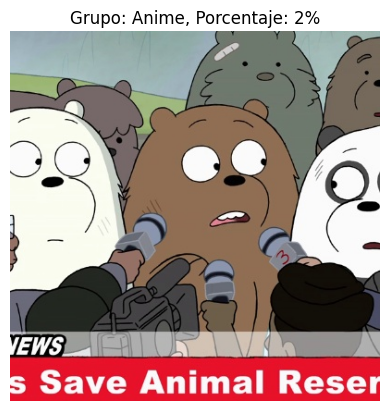

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas

# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/balanced_train/cartoon/WeBareBearsTheMovie_975.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Cálculo del porcentaje y del grupo
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]

print(grupo, round(porcentaje))

# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f'Grupo: {grupo}, Porcentaje: {round(porcentaje)}%')
plt.axis('off')  # Ocultar los ejes
plt.show()


1/1 [==============================] - 0s 139ms/step
3D: 0.00%
Anime: 1.60%
StopMotion: 0.33%
cartoon: 0.41%


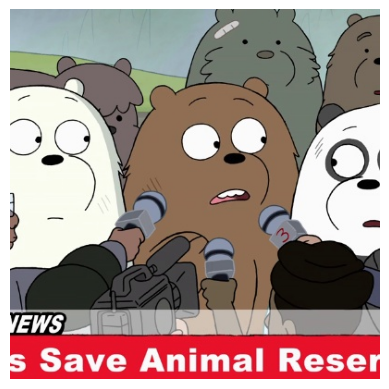

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas


# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/balanced_train/cartoon/WeBareBearsTheMovie_975.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Imprimir todos los porcentajes de predicción
for i, label in enumerate(labels):
    print(f"{label}: {result[0][i] * 100:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]


# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()


1/1 [==============================] - 0s 134ms/step
3D: 0.00%
Anime: 3.15%
StopMotion: 0.31%
cartoon: 0.05%


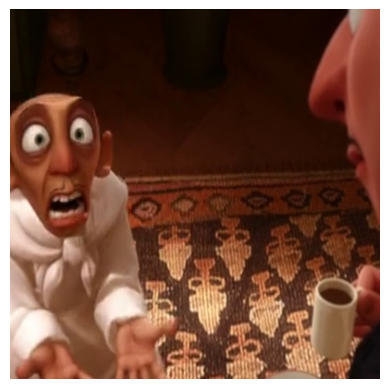

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas


# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/balanced_train/3D/Ratatouille_996.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Imprimir todos los porcentajes de predicción
for i, label in enumerate(labels):
    print(f"{label}: {result[0][i] * 100:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]


# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

1/1 [==============================] - 0s 126ms/step
3D: 0.00%
Anime: 0.81%
StopMotion: 0.19%
cartoon: 0.31%


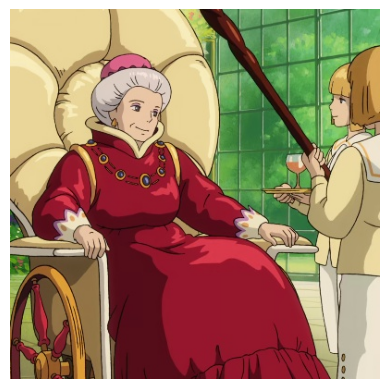

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas


# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/train/Anime/ElCastilloAmbulante_depurado/ElCastilloAmbulante_1000.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Imprimir todos los porcentajes de predicción
for i, label in enumerate(labels):
    print(f"{label}: {result[0][i] * 100:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]


# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

1/1 [==============================] - 0s 73ms/step
3D: 0.00%
Anime: 14.32%
StopMotion: 1.58%
cartoon: 0.16%


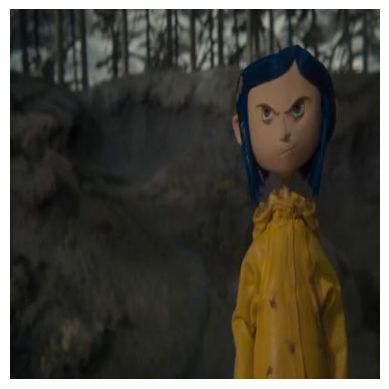

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas


# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/train/StopMotion/Coraline_depurado/frame_0261.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Imprimir todos los porcentajes de predicción
for i, label in enumerate(labels):
    print(f"{label}: {result[0][i] * 100:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]


# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas


# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/train/StopMotion/Coraline_depurado/frame_0261.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Imprimir todos los porcentajes de predicción
for i, label in enumerate(labels):
    print(f"{label}: {result[0][i] * 100:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]


# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

1/1 [==============================] - 0s 152ms/step
3D: 0.00%
Anime: 2.93%
StopMotion: 1.40%
cartoon: 1.60%


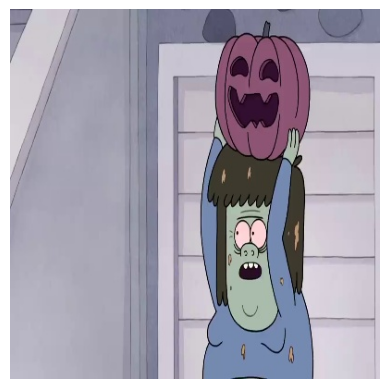

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas


# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/train/cartoon/USM 1_depurado/frame_0396.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Imprimir todos los porcentajes de predicción
for i, label in enumerate(labels):
    print(f"{label}: {result[0][i] * 100:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]


# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

1/1 [==============================] - 0s 166ms/step
3D: 0.00%
Anime: 0.49%
StopMotion: 0.08%
cartoon: 0.14%


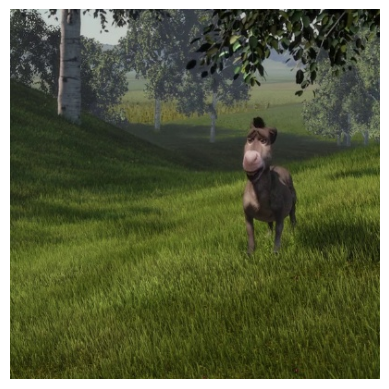

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas


# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/train/3D/Shrek1_Depuradas/Shrek01_1009.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Imprimir todos los porcentajes de predicción
for i, label in enumerate(labels):
    print(f"{label}: {result[0][i] * 100:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]


# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

1/1 [==============================] - 0s 120ms/step
3D: 0.00%
Anime: 2.08%
StopMotion: 0.13%
cartoon: 0.08%


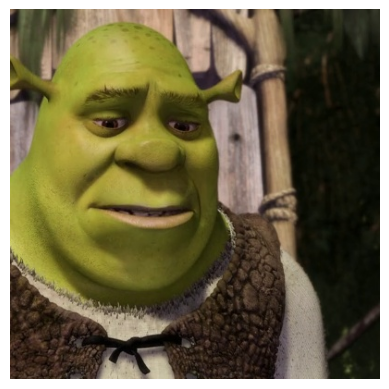

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas


# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/train/3D/Shrek1_Depuradas/Shrek01_1046.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Imprimir todos los porcentajes de predicción
for i, label in enumerate(labels):
    print(f"{label}: {result[0][i] * 100:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]


# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

1/1 [==============================] - 0s 91ms/step
3D: 0.00%
Anime: 46.55%
StopMotion: 1.63%
cartoon: 0.03%


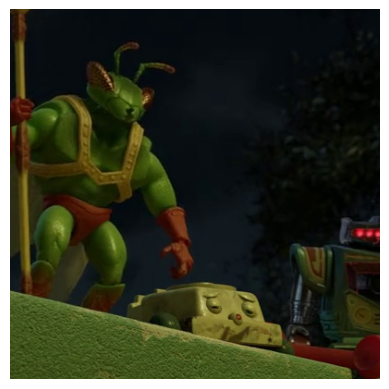

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas


# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/train/3D/ToyStory3_depurado/ToyStory3_1054.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Imprimir todos los porcentajes de predicción
for i, label in enumerate(labels):
    print(f"{label}: {result[0][i] * 100:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]


# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

1/1 [==============================] - 0s 127ms/step
3D: 0.00%
Anime: 1.43%
StopMotion: 0.48%
cartoon: 0.65%


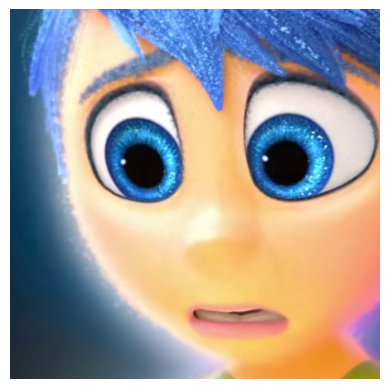

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas


# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/train/3D/InsideOut/InsideOut_1014.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Imprimir todos los porcentajes de predicción
for i, label in enumerate(labels):
    print(f"{label}: {result[0][i] * 100:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]


# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

1/1 [==============================] - 0s 136ms/step
3D: 0.00%
Anime: 1.55%
StopMotion: 0.46%
cartoon: 0.63%


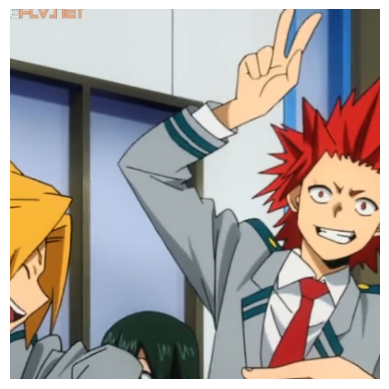

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas


# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/train/Anime/Capturas  boku no hero_depurado/frame_0066.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Imprimir todos los porcentajes de predicción
for i, label in enumerate(labels):
    print(f"{label}: {result[0][i] * 100:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]


# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

1/1 [==============================] - 0s 160ms/step
3D: 0.00%
Anime: 1.23%
StopMotion: 0.27%
cartoon: 0.34%


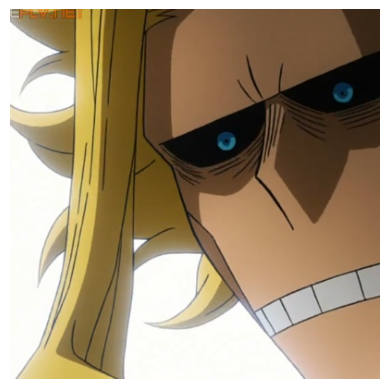

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas

# Inicializar el diccionario de porcentajes
percentages = {label: 0 for label in labels}

# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/train/Anime/Capturas  boku no hero_depurado/frame_0062.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Actualizar el diccionario de porcentajes con los resultados de la predicción
for i, label in enumerate(labels):
    percentages[label] = result[0][i] * 100

# Imprimir todos los porcentajes de predicción
for label, percentage in percentages.items():
    print(f"{label}: {percentage:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]

# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()


1/1 [==============================] - 0s 110ms/step
3D: 0.00%
Anime: 1.31%
StopMotion: 0.47%
cartoon: 0.74%


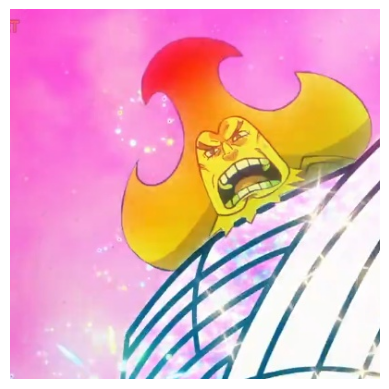

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas

# Inicializar el diccionario de porcentajes
percentages = {label: 0 for label in labels}

# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/train/Anime/CapturasOnePiece/left_frame_0020.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Actualizar el diccionario de porcentajes con los resultados de la predicción
for i, label in enumerate(labels):
    percentages[label] = result[0][i] * 100

# Imprimir todos los porcentajes de predicción
for label, percentage in percentages.items():
    print(f"{label}: {percentage:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]

# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()


1/1 [==============================] - 0s 103ms/step
3D: 0.00%
Anime: 62.66%
StopMotion: 2.04%
cartoon: 0.05%


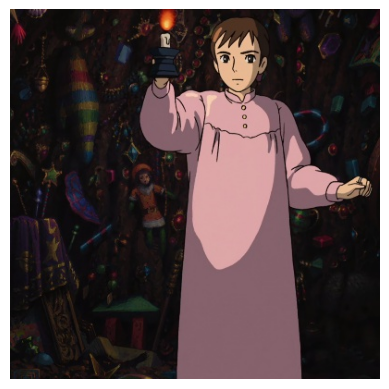

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas

# Inicializar el diccionario de porcentajes
percentages = {label: 0 for label in labels}

# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/train/Anime/ElCastilloAmbulante_depurado/ElCastilloAmbulante_1042.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Actualizar el diccionario de porcentajes con los resultados de la predicción
for i, label in enumerate(labels):
    percentages[label] = result[0][i] * 100

# Imprimir todos los porcentajes de predicción
for label, percentage in percentages.items():
    print(f"{label}: {percentage:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]

# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

1/1 [==============================] - 0s 72ms/step
3D: 0.00%
Anime: 1.24%
StopMotion: 0.20%
cartoon: 0.19%


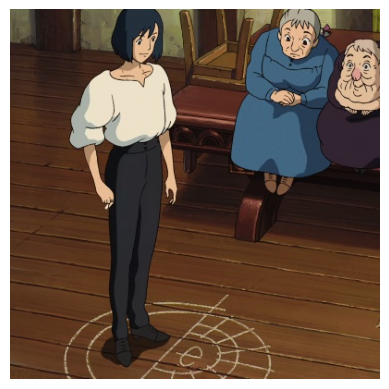

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas

# Inicializar el diccionario de porcentajes
percentages = {label: 0 for label in labels}

# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/train/Anime/ElCastilloAmbulante_depurado/ElCastilloAmbulante_1081.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Actualizar el diccionario de porcentajes con los resultados de la predicción
for i, label in enumerate(labels):
    percentages[label] = result[0][i] * 100

# Imprimir todos los porcentajes de predicción
for label, percentage in percentages.items():
    print(f"{label}: {percentage:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]

# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

1/1 [==============================] - 0s 111ms/step
3D: 0.00%
Anime: 0.75%
StopMotion: 0.17%
cartoon: 0.28%


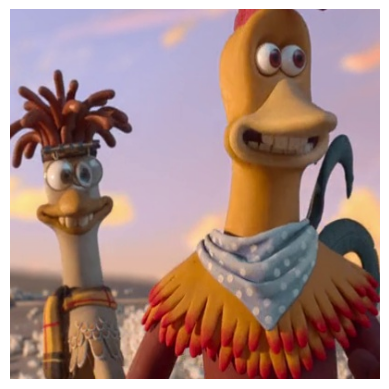

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas

# Inicializar el diccionario de porcentajes
percentages = {label: 0 for label in labels}

# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/train/StopMotion/ChickenRunDawnoftheNugget_Depurado/ChickenRunDawnoftheNugget_1006.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Actualizar el diccionario de porcentajes con los resultados de la predicción
for i, label in enumerate(labels):
    percentages[label] = result[0][i] * 100

# Imprimir todos los porcentajes de predicción
for label, percentage in percentages.items():
    print(f"{label}: {percentage:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]

# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

1/1 [==============================] - 0s 116ms/step
3D: 0.00%
Anime: 1.20%
StopMotion: 0.37%
cartoon: 0.54%


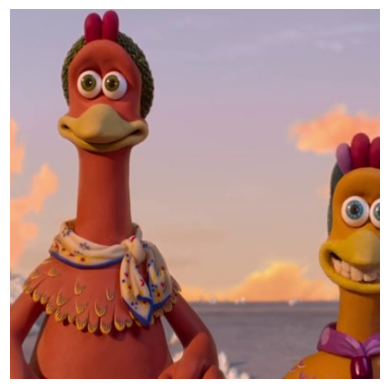

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas

# Inicializar el diccionario de porcentajes
percentages = {label: 0 for label in labels}

# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/train/StopMotion/ChickenRunDawnoftheNugget_Depurado/ChickenRunDawnoftheNugget_1020.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Actualizar el diccionario de porcentajes con los resultados de la predicción
for i, label in enumerate(labels):
    percentages[label] = result[0][i] * 100

# Imprimir todos los porcentajes de predicción
for label, percentage in percentages.items():
    print(f"{label}: {percentage:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]

# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

1/1 [==============================] - 0s 71ms/step
3D: 0.00%
Anime: 0.63%
StopMotion: 0.11%
cartoon: 0.18%


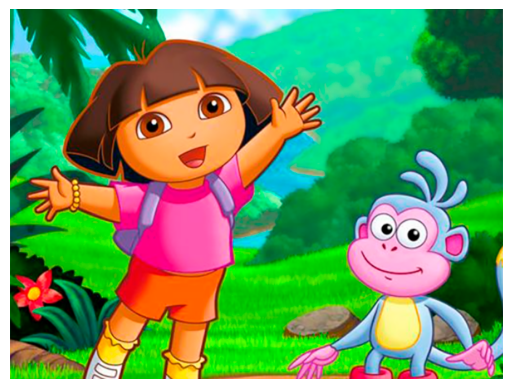

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas

# Inicializar el diccionario de porcentajes
percentages = {label: 0 for label in labels}

# Cargar una imagen para predecir
ruta_predict = '/content/dora-la-exploradora.png'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Actualizar el diccionario de porcentajes con los resultados de la predicción
for i, label in enumerate(labels):
    percentages[label] = result[0][i] * 100

# Imprimir todos los porcentajes de predicción
for label, percentage in percentages.items():
    print(f"{label}: {percentage:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]

# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

1/1 [==============================] - 0s 123ms/step
3D: 0.00%
Anime: 0.88%
StopMotion: 0.23%
cartoon: 0.38%


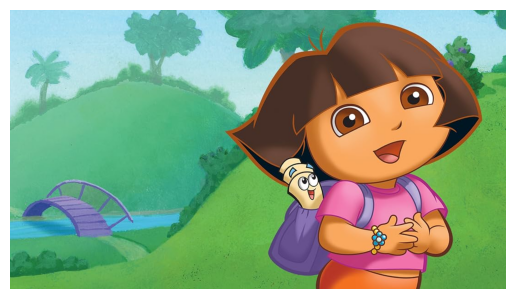

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas

# Inicializar el diccionario de porcentajes
percentages = {label: 0 for label in labels}

# Cargar una imagen para predecir
ruta_predict = '/content/8b8dd79e4cc0a10a8945865376457022a39cc1013cbb0ba6b1fa808b45780b89._SX1080_FMjpg_.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Actualizar el diccionario de porcentajes con los resultados de la predicción
for i, label in enumerate(labels):
    percentages[label] = result[0][i] * 100

# Imprimir todos los porcentajes de predicción
for label, percentage in percentages.items():
    print(f"{label}: {percentage:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]

# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

1/1 [==============================] - 0s 131ms/step
3D: 0.00%
Anime: 0.81%
StopMotion: 0.19%
cartoon: 0.31%


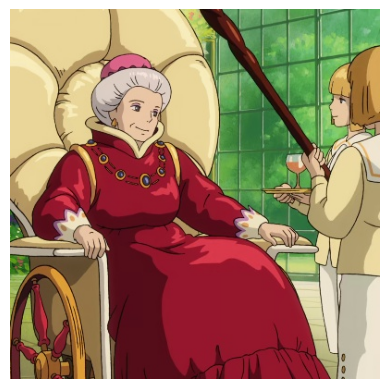

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Definir las etiquetas
labels = ["3D", "Anime", "StopMotion", "cartoon"]  # Asegúrate de que estas coincidan con tus etiquetas

# Inicializar el diccionario de porcentajes
percentages = {label: 0 for label in labels}

# Cargar una imagen para predecir
ruta_predict = '/content/drive/MyDrive/train/Anime/ElCastilloAmbulante_depurado/ElCastilloAmbulante_1000.jpg'  # Asegúrate de que esta ruta sea correcta
img = cv2.imread(ruta_predict)
img = cv2.resize(img, (400, 400))  # Asegúrate de que el tamaño coincida con el tamaño esperado por tu modelo
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el lote

# Realizar la predicción
result = model.predict(img)

# Actualizar el diccionario de porcentajes con los resultados de la predicción
for i, label in enumerate(labels):
    percentages[label] = result[0][i] * 100

# Imprimir todos los porcentajes de predicción
for label, percentage in percentages.items():
    print(f"{label}: {percentage:.2f}%")

# Obtener el grupo con la mayor probabilidad
porcentaje = max(result[0]) * 100
grupo = labels[np.argmax(result[0])]

# Mostrar la imagen predicha usando matplotlib
img = cv2.cvtColor(cv2.imread(ruta_predict), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

In [ ]:
import os
from collections import Counter

ruta_train = '/content/drive/MyDrive/train/'
labels = os.listdir(ruta_train)
label_counts = Counter()

for label in labels:
    subdirectory = os.path.join(ruta_train, label)
    if os.path.isdir(subdirectory):
        image_files = os.listdir(subdirectory)
        label_counts[label] += len(image_files)

print("Distribution of training data:", label_counts)


Distribution of training data: Counter({'3D': 8, 'StopMotion': 8, 'Anime': 5, 'cartoon': 4})
